In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit


In [2]:
#analyze input directory to get name of file, size, num of lines in file in a dataframe
def analyze_input_dir(input_dir):
    files = [file for file in os.listdir(input_dir) if '__' in file]
    data = [
        [file, os.path.getsize(os.path.join(input_dir, file)), sum(1 for line in open(os.path.join(input_dir, file)))]
        for file in files
    ]
    df = pd.DataFrame(data, columns=['file_name', 'file_size', 'num_lines'])
    print('found {} files in input directory'.format(len(df)))
    print('found {} empty files in directory'.format(len(df[df['num_lines'] == 0])))


In [3]:
def make_df_from_files(directory):
    files = [file for file in os.listdir(directory) if '__' in file and os.path.getsize(os.path.join(directory, file)) > 0]
    data_list = []
    for file in files:
        with open(os.path.join(directory, file)) as f:
            for index, line in enumerate(f):
                data = json.loads(line)
                row = {
                    'filename': file,
                    'index': index,
                    'start_time': data['start_time'],
                    'end_time': data['stop_time'],
                    'polarization': data['pol'],
                    'area': data['area'],
                    'cc': data['cc'],
                    'uwave_freq': data['uwave_freq'],
                    'base_file': data['base_file'],
                    'baseline': data['baseline'],
                    'phase': data['phase'],
                    'fitsub': data['fitsub'],
                    'basesub': data['basesub'],
                    'freq_list': data['freq_list']
                    
                }
                #status and epics contain the same information but the keys changed during the experiment
                if 'epics' in data:
                    for key, value in data['epics'].items():
                        row[f'{key}'] = value
                elif 'status' in data:
                    for key, value in data['status'].items():
                        row[f'{key}'] = value
                        
                if 'label' in data:
                    row['label'] = data['label']
                else:
                    row['label'] = 'No Label'
                    
                data_list.append(row)
    df = pd.DataFrame(data_list)
    return df

In [4]:
def quadratic_function(x, a, b, c):
    return a * x ** 2 + b * x + c

In [5]:
from sklearn.metrics import r2_score

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [6]:
def calculate_rss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).sum()


In [7]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

In [8]:
def plot_fits(directory, frequency, threshold):
    files = [file for file in os.listdir(directory) if '__' in file and os.path.getsize(os.path.join(directory, file)) > 0]
    print('I\'ve found', len(files), 'files with fit distributions')
    records =[]
    
    #selected_files = np.random.choice(files, nfiles, replace=False)
    for file in files:
        fitsub_data = []  # Store fitsub data for the current file
        freq_lists = []   # Store frequency lists for the current file

        with open(os.path.join(directory, file), 'r') as f:
            json_objects = [json.loads(line) for line in f]
            print('I\'ve found', len(json_objects), 'objects in', file)

            for index,obj in enumerate(json_objects):
                if 'fitsub' in obj and obj['fitsub']:  # Check if 'fitsub' key exists and is not empty
                    fitsub = np.array(obj['fitsub'])
                    freq_list = np.array(obj['freq_list'])
                    
                    # Finding both max and min peaks
                    index_max_fitsub = np.argmax(fitsub)
                    index_min_fitsub = np.argmin(fitsub)
                    freq_at_max_fitsub = freq_list[index_max_fitsub]
                    freq_at_min_fitsub = freq_list[index_min_fitsub]
                    
                    # Check if the frequency at max or min is approximately 212.9 within a given threshold
                    max_condition = abs(freq_at_max_fitsub - frequency) <= threshold
                    min_condition = abs(freq_at_min_fitsub - frequency) <= threshold
                    
                    if max_condition or min_condition:
                        is_kept = True
                        freq_lists.append(freq_list)
                        fitsub_data.append(fitsub)
                    else:
                        is_kept = False
                        #print('not keeping distributio for file', file, 'index', index)
                    
                    records.append({'filename': file, 'index': index, 'kept': is_kept})

            #fig, axs = plt.subplots(figsize=(24, 6))
            #for i in range(len(fitsub_data)):
            #    axs.scatter(freq_lists[i], fitsub_data[i], label=f'fit {i+1}')
            #axs.set_title('Scatterplot of Normalized Signal vs Frequency')
            #axs.set_xlabel('Frequency')
            #axs.set_ylabel('Normalized Signal')

            #plt.suptitle(f'fitsub Analysis for {file}')
            #plt.tight_layout()
            #plt.show()
    
    df = pd.DataFrame(records)
    return df
    
    

In [9]:
proton_data = make_df_from_files('/group/poltar/HallB/RGC/data-p/')

In [10]:
proton_data.head(10)

,filename,index,start_time,end_time,polarization,area,cc,uwave_freq,base_file,baseline,...,TGT:PT12:NMR_T,TGT:PT12:Fridge_F,B_SOL:MPS:I_ZFCT,scaler_calc1,B_DAQ:run_number,B_DAQ:HEL:60m:29:asycorr,TGT:PT12:Target_Dose,TGT:PT12:Bath_HTR_lvl,TGT:PT12:Separator_F,TGT:PT12:HT_Bath
0,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,0,2023-01-25 20:52:09.812560+00:00,2023-01-25 20:52:21.867311+00:00,-8.876080e-09,5.125758e-09,-1.731662,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,1,2023-01-25 20:52:21.867311+00:00,2023-01-25 20:52:33.726570+00:00,-8.876080e-09,5.125758e-09,-1.731662,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,2,2023-01-25 20:52:33.835478+00:00,2023-01-25 20:52:46.534122+00:00,3.517931e+03,-2.031535e+03,-1.731662,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,3,2023-01-25 20:52:33.835478+00:00,2023-01-25 20:52:46.534122+00:00,3.517931e+03,-2.031535e+03,-1.731662,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,4,2023-01-25 20:52:33.835478+00:00,2023-01-25 20:52:46.534122+00:00,-2.890769e-03,1.669361e-03,-1.731662,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,5,2023-01-25 20:52:33.835478+00:00,2023-01-25 20:52:46.534122+00:00,-2.890769e-03,1.669361e-03,-1.731662,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,NaN,NaN,0.077640,0.0,17467.0,0.0,NaN,NaN,NaN,NaN
6,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,6,2023-01-25 20:52:33.835478+00:00,2023-01-25 20:52:46.534122+00:00,-2.890769e-03,1.669361e-03,-1.731662,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,NaN,NaN,0.076950,0.0,17467.0,0.0,NaN,NaN,NaN,NaN
7,2022-06-19_19-37-21__2022-06-19_19-43-11.txt,0,2022-06-19 19:38:37.265630+00:00,2022-06-19 19:38:49.944211+00:00,-7.725910e-03,2.207403e-03,-3.500000,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,6.5417,46.765850,2420.043701,NaN,NaN,NaN,NaN,0.0,79.838254,NaN
8,2022-06-19_19-37-21__2022-06-19_19-43-11.txt,1,2022-06-19 19:38:49.950689+00:00,2022-06-19 19:39:02.644504+00:00,-6.382789e-03,1.823654e-03,-3.500000,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,6.5051,39.905394,2420.045410,NaN,NaN,NaN,NaN,0.0,80.082399,NaN
9,2022-06-19_19-37-21__2022-06-19_19-43-11.txt,2,2022-06-19 19:39:02.650523+00:00,2022-06-19 19:39:15.337465+00:00,-8.890381e-03,2.540109e-03,-3.500000,0.0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,5.9423,41.004044,2420.044434,NaN,NaN,NaN,NaN,0.0,80.000000,NaN


In [11]:
proton_data.shape

(111684, 29)

In [12]:
proton_data.describe()

,index,polarization,area,cc,uwave_freq,TGT:PT12:Bath_LL,TGT:PT12:VaporPressure_T,TGT:PT12:Bath_Top_T,TGT:PT12:Bath_Bottom_T,TGT:PT12:NMR_T,TGT:PT12:Fridge_F,B_SOL:MPS:I_ZFCT,scaler_calc1,B_DAQ:run_number,B_DAQ:HEL:60m:29:asycorr,TGT:PT12:Target_Dose,TGT:PT12:Bath_HTR_lvl,TGT:PT12:Separator_F,TGT:PT12:HT_Bath
count,111684.000000,111684.000000,111684.000000,111684.000000,1.111070e+05,111579.000000,109216.000000,111579.000000,111579.000000,109218.000000,111579.000000,107295.000000,88357.000000,57999.000000,57999.000000,8.099700e+04,50676.000000,53603.000000,959.0
mean,235.192301,0.181859,-0.092160,-3.109383,1.272819e+09,70.143429,1.078070,5.278498,5.188988,3.613630,18.083492,1468.200114,2.180245,16721.023328,-0.000476,8.455650e+14,0.258900,38.288346,0.0
std,146.204868,14.896109,8.600044,2.351232,1.329575e+10,13.745887,0.337741,33.669433,33.310853,8.086189,7.493428,1762.241099,2.884136,6057.739522,0.014563,8.455880e+14,4.350353,8.530634,0.0
min,0.000000,-2.289422,-2031.534661,-369.308200,0.000000e+00,-7.287224,0.000000,0.000000,0.000000,0.000000,-29.169146,-2421.320068,-81.730302,0.000000,-0.062460,-1.754280e+10,0.000000,-0.393683,0.0
25%,106.000000,-0.512685,-0.160755,-3.738274,1.400755e+02,70.311284,1.067161,1.242900,1.233500,2.983700,16.067750,2392.515381,-0.000441,17143.000000,-0.016022,1.010084e+13,0.000000,39.908446,0.0
50%,230.000000,0.012572,-0.006041,-3.173865,1.401257e+02,72.528420,1.081312,1.290600,1.261500,3.198200,19.076829,2420.074463,0.005297,17328.000000,0.000000,6.673393e+14,0.000000,39.975586,0.0
75%,360.000000,0.634766,0.120303,-1.626101,1.404909e+02,74.940340,1.093651,1.337300,1.301500,3.539100,22.174411,2420.218506,3.962039,17608.000000,0.015547,1.406057e+15,0.000000,40.039673,0.0
max,500.000000,3517.931373,1.435575,1.000000,1.402605e+11,134.671708,70.238820,299.066000,298.269000,277.663000,99.998474,2420.478760,45.139042,217749.000000,1.211095,4.271478e+15,100.000000,91.334401,0.0


In [13]:
#get the number of entries where the 'label' is none, TE, and polarize 
print('number of entries where label is None:', len(proton_data[proton_data['label']=='No Label']))
print('number of entries where label is TE:', len(proton_data[proton_data['label'] == 'TE']))
print('number of entries where label is polarize:', len(proton_data[proton_data['label'] == 'Polarize']))

unique_labels = proton_data['label'].unique()
print("Unique labels in the DataFrame:", unique_labels)

number of entries where label is None: 5211
number of entries where label is TE: 5487
number of entries where label is polarize: 94010
Unique labels in the DataFrame: ['None' 'Baseline' 'Junk' 'No Label' 'TE' 'Polarize' 'CH2' 'TE-residue'
 'CH2 TE']


Text(0.5, 1.0, 'Distribution of Labels')

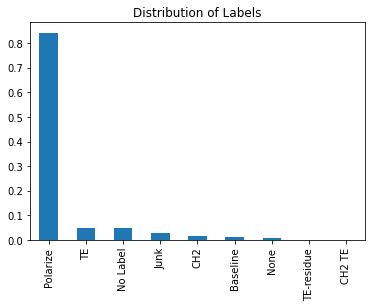

In [14]:
#plot the distribution of the 'label' column by percentage
proton_data['label'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Labels')



In [15]:
#save TE events to separate dataframe
te_data = proton_data[proton_data['label'] == 'TE']
print('Number of TE events:', len(te_data))
te_data.to_csv('te_data_proton.csv', index=False)

Number of TE events: 5487


In [16]:
proton_data_polarize = proton_data[proton_data['label'] == 'Polarize']
print('Number of Polarize events:', len(proton_data_polarize))
#proton_data_polarize.to_csv('polarize_data_proton.csv', index=False)

Number of Polarize events: 94010


In [17]:
proton_data_polarize.shape

(94010, 29)

In [18]:
proton_data_polarize.describe()

,index,polarization,area,cc,uwave_freq,TGT:PT12:Bath_LL,TGT:PT12:VaporPressure_T,TGT:PT12:Bath_Top_T,TGT:PT12:Bath_Bottom_T,TGT:PT12:NMR_T,TGT:PT12:Fridge_F,B_SOL:MPS:I_ZFCT,scaler_calc1,B_DAQ:run_number,B_DAQ:HEL:60m:29:asycorr,TGT:PT12:Target_Dose,TGT:PT12:Bath_HTR_lvl,TGT:PT12:Separator_F,TGT:PT12:HT_Bath
count,94010.000000,94010.000000,94010.000000,94010.000000,93551.000000,94009.000000,94007.000000,94009.000000,94009.000000,94009.000000,94009.000000,94009.000000,78137.000000,48921.000000,48921.000000,7.091900e+04,45088.000000,45088.000000,0.0
mean,242.725721,0.130645,-0.064676,-3.142837,135.214357,71.715569,1.069390,1.359816,1.314902,3.433647,19.477759,1484.254196,2.381886,17008.920934,-0.000584,8.856038e+14,0.132674,40.005044,NaN
std,144.110365,0.573288,0.259411,1.682631,26.107123,9.537597,0.309994,2.513128,1.795500,2.111180,5.226403,1798.763830,2.945559,5961.571821,0.015639,8.422025e+14,2.896322,1.094006,NaN
min,0.000000,-2.289422,-1.612906,-9.126712,0.000000,-7.287224,0.000000,0.000000,0.000000,0.000000,-29.169146,-2421.320068,-81.730302,0.000000,-0.062460,-1.754280e+10,0.000000,34.885176,NaN
25%,117.000000,-0.535952,-0.185790,-3.738274,140.100192,70.816358,1.067814,1.249300,1.235800,3.029800,16.989395,2419.241699,-0.000221,17143.000000,-0.017194,4.076161e+13,0.000000,39.917601,NaN
50%,239.000000,0.362713,-0.091439,-3.173865,140.130565,72.812238,1.081460,1.292100,1.260400,3.234200,19.858091,2420.095703,0.007283,17223.000000,0.000000,7.431764e+14,0.000000,39.978637,NaN
75%,366.000000,0.643110,0.136581,-1.626101,140.494280,74.966188,1.092559,1.332300,1.295900,3.583400,22.421607,2420.226074,4.014787,17603.000000,0.016771,1.441924e+15,0.000000,40.039673,NaN
max,500.000000,2.572225,1.435575,1.000000,140.754309,101.939394,70.238820,184.652000,100.661000,64.476000,99.998474,2420.478760,45.139042,217749.000000,1.211095,4.271478e+15,100.000000,91.334401,NaN


In [19]:
proton_data_polarize = proton_data_polarize.drop(columns=['TGT:PT12:Bath_HTR_lvl', 'TGT:PT12:HT_Bath','B_DAQ:HEL:60m:29:asycorr'])

In [20]:
filtered_proton_polarize = proton_data_polarize.query(
        '-1 < polarization < 1 and not (-0.1 < polarization < 0.1) and uwave_freq > 100 and `TGT:PT12:Target_Dose` > 0 and `TGT:PT12:Bath_Top_T` < 10 and `TGT:PT12:Bath_Bottom_T` < 10 and area != 0'
)
filtered_proton_polarize.shape
#filtered_proton_polarize.to_csv('filtered_proton_polarize.csv', index=False)

(54758, 26)

In [21]:
#get the counts with positive polarization and the counts with negative polarization
positive_polarization = filtered_proton_polarize[filtered_proton_polarize['polarization'] > 0]
negative_polarization = filtered_proton_polarize[filtered_proton_polarize['polarization'] < 0]
print('Number of events with positive polarization:', len(positive_polarization))
print('Number of events with negative polarization:', len(negative_polarization))


Number of events with positive polarization: 32752
Number of events with negative polarization: 22006


### we should double check the fitsub distributions in case there is anything weird that made it through the above cuts

In [22]:
#call plot fits on raw data files in /group. this will probably take awhile to run
df_fits = plot_fits('/group/poltar/HallB/RGC/data-p/', 212.9, 0.1)

I've found 449 files with fit distributions
I've found 7 objects in 2023-01-25_20-51-34__2023-01-25_21-13-38.txt
I've found 4 objects in 2022-06-19_19-37-21__2022-06-19_19-43-11.txt
I've found 6 objects in 2022-06-15_19-02-42__2022-06-15_19-07-01.txt
I've found 83 objects in 2022-06-06_21-06-25__2022-06-06_22-00-01.txt
I've found 174 objects in 2023-03-20_14-02-18__2023-03-20_20-41-32.txt
I've found 1 objects in 2023-03-21_03-21-06__2023-03-21_03-24-05.txt
I've found 501 objects in 2023-02-19_19-42-49__2023-02-20_06-44-22.txt
I've found 5 objects in 2022-06-08_14-15-44__2022-06-08_14-17-04.txt
I've found 2 objects in 2023-01-27_16-19-14__2023-01-27_16-22-23.txt
I've found 501 objects in 2022-11-04_03-48-22__2022-11-04_14-50-00.txt
I've found 5 objects in 2023-03-30_18-43-38__2023-03-30_18-50-48.txt
I've found 1 objects in 2022-06-08_14-34-20__2022-06-08_14-34-52.txt
I've found 9 objects in 2022-06-08_15-56-08__2022-06-08_15-57-03.txt
I've found 15 objects in 2023-03-30_17-55-05__2023-0

In [23]:
df_fits.shape
print('number of fits kept:', len(df_fits[df_fits['kept'] == True]))
print('number of fits not kept:', len(df_fits[df_fits['kept'] == False]))

number of fits kept: 99695
number of fits not kept: 11989


In [24]:
df_fits.head(5)

,filename,index,kept
0,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,0,False
1,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,1,False
2,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,2,False
3,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,3,False
4,2023-01-25_20-51-34__2023-01-25_21-13-38.txt,4,False


In [25]:
merged_df = pd.merge(filtered_proton_polarize, df_fits, on=['filename', 'index'])
merged_df.shape


(54758, 27)

In [26]:
#keep only events in the merged_df where the fits were kept
merged_df = merged_df[merged_df['kept'] == True]
merged_df.shape

(54630, 27)

In [27]:
merged_df.to_csv('proton_data_cleaned.csv', index=False)

In [28]:
#plot some random fitsub distributions from merged_df

## deuteron data 

In [29]:
deuteron_data = make_df_from_files('/group/poltar/HallB/RGC/data-d/')

In [30]:
deuteron_data.shape

(72671, 28)

In [31]:
#get the number of entries where the 'label' is none, TE, and polarize 
print('number of entries where label is None:', len(deuteron_data[deuteron_data['label']=='None']))
print('number of entries where label is TE:', len(deuteron_data[deuteron_data['label'] == 'TE']))
print('number of entries where label is polarize:', len(deuteron_data[deuteron_data['label'] == 'Polarize']))
print('total labels:', len(deuteron_data[deuteron_data['label'].isnull()]) + len(deuteron_data[deuteron_data['label'] == 'TE']) + len(deuteron_data[deuteron_data['label'] == 'Polarize']))

number of entries where label is None: 124
number of entries where label is TE: 1448
number of entries where label is polarize: 64764
total labels: 66212


Text(0.5, 1.0, 'Distribution of Labels')

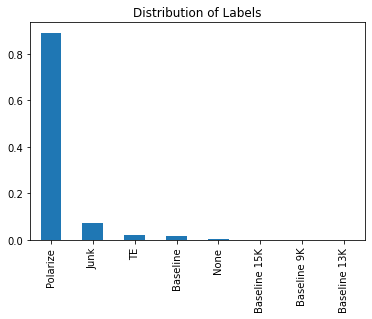

In [32]:
deuteron_data['label'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Labels')

In [33]:
#get polarize deuteron events
deuteron_data_polarize = deuteron_data[deuteron_data['label'] == 'Polarize']
deuteron_data_polarize.shape

(64764, 28)

In [34]:
filtered_deuteron_polarize = deuteron_data_polarize.query(
        '-1 < polarization < 1 and not (-0.1 < polarization < 0.1) and uwave_freq > 100 and `TGT:PT12:Target_Dose` > 0 and `TGT:PT12:Bath_Top_T` < 10 and `TGT:PT12:Bath_Bottom_T` < 10 and area != 0'
)
filtered_deuteron_polarize.shape

(45463, 28)

In [35]:
df_fits_deuteron = plot_fits('/group/poltar/HallB/RGC/data-d/', 32.7, 0.2)

I've found 210 files with fit distributions
I've found 501 objects in 2022-09-08_21-34-44__2022-09-09_11-00-11.txt
I've found 151 objects in 2022-07-19_19-07-58__2022-07-20_00-06-02.txt
I've found 501 objects in 2022-07-29_23-49-20__2022-07-30_13-14-47.txt
I've found 501 objects in 2023-02-07_15-30-40__2023-02-08_04-52-58.txt
I've found 501 objects in 2022-10-20_19-30-52__2022-10-21_08-56-18.txt
I've found 113 objects in 2022-08-11_13-04-03__2022-08-11_14-03-18.txt
I've found 501 objects in 2023-03-17_14-50-00__2023-03-17_22-42-48.txt
I've found 501 objects in 2023-02-05_09-22-47__2023-02-07_02-15-49.txt
I've found 2 objects in 2022-08-11_12-30-20__2022-08-11_12-32-04.txt
I've found 501 objects in 2023-02-12_19-10-07__2023-02-13_08-35-33.txt
I've found 2 objects in 2022-07-06_20-40-06__2022-07-06_20-42-31.txt
I've found 501 objects in 2022-09-21_22-03-08__2022-09-22_11-28-31.txt
I've found 501 objects in 2022-08-06_10-16-59__2022-08-06_23-42-26.txt
I've found 53 objects in 2023-03-15_1

In [36]:
df_fits_deuteron.shape

(72671, 3)

In [37]:
merged_df_deuteron = pd.merge(filtered_deuteron_polarize, df_fits_deuteron, on=['filename', 'index'])
merged_df_deuteron.shape


(45463, 29)

In [38]:
merged_df_deuteron

,filename,index,start_time,end_time,polarization,area,cc,uwave_freq,base_file,baseline,...,TGT:PT12:Bath_HTR_lvl,TGT:PT12:Fridge_F,TGT:PT12:Separator_F,B_SOL:MPS:I_ZFCT,scaler_calc1,TGT:PT12:Target_Dose,label,B_DAQ:run_number,B_DAQ:HEL:60m:29:asycorr,kept
0,2022-09-08_21-34-44__2022-09-09_11-00-11.txt,0,2022-09-08 21:34:44.171695+00:00,2022-09-08 21:36:20.619122+00:00,0.362287,-0.256941,-1.41,140.174266,data-d/recent_baselines.txt,"[-2.0423326910876236, -2.042240168440875, -2.0...",...,0.0,22.528420,39.874876,2420.085693,6.739572,1.275645e+15,Polarize,NaN,NaN,True
1,2022-09-08_21-34-44__2022-09-09_11-00-11.txt,1,2022-09-08 21:36:20.625405+00:00,2022-09-08 21:37:57.068387+00:00,0.362702,-0.257235,-1.41,140.173818,data-d/recent_baselines.txt,"[-2.0423326910876236, -2.042240168440875, -2.0...",...,0.0,22.363622,39.908446,2420.090820,6.725447,1.277089e+15,Polarize,NaN,NaN,True
2,2022-09-08_21-34-44__2022-09-09_11-00-11.txt,2,2022-09-08 21:37:57.073880+00:00,2022-09-08 21:39:33.522757+00:00,0.362293,-0.256945,-1.41,140.173964,data-d/recent_baselines.txt,"[-2.0423326910876236, -2.042240168440875, -2.0...",...,0.0,21.719692,39.951171,2420.089111,-0.001104,1.278708e+15,Polarize,NaN,NaN,True
3,2022-09-08_21-34-44__2022-09-09_11-00-11.txt,3,2022-09-08 21:39:33.522995+00:00,2022-09-08 21:41:09.972411+00:00,0.363027,-0.257466,-1.41,140.172946,data-d/recent_baselines.txt,"[-2.0423326910876236, -2.042240168440875, -2.0...",...,0.0,21.252766,40.112917,2420.084229,-0.001545,1.279656e+15,Polarize,NaN,NaN,True
4,2022-09-08_21-34-44__2022-09-09_11-00-11.txt,4,2022-09-08 21:41:09.972708+00:00,2022-09-08 21:42:46.427020+00:00,0.362303,-0.256953,-1.41,140.175364,data-d/recent_baselines.txt,"[-2.0423326910876236, -2.042240168440875, -2.0...",...,0.0,23.184558,40.085451,2420.088867,6.866475,1.281303e+15,Polarize,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45458,2022-08-03_19-28-11__2022-08-04_08-53-38.txt,496,2022-08-04 08:45:36.175384+00:00,2022-08-04 08:47:12.633141+00:00,0.596849,-0.041162,-14.50,140.203283,data-d/current_2022-08-01_15-19-14.txt,"[-5.761123644126799, -5.76068141004705, -5.759...",...,0.0,20.816358,39.966430,2420.215088,3.797837,2.187311e+15,Polarize,NaN,NaN,True
45459,2022-08-03_19-28-11__2022-08-04_08-53-38.txt,497,2022-08-04 08:47:12.634413+00:00,2022-08-04 08:48:49.092788+00:00,0.605783,-0.041778,-14.50,140.202364,data-d/current_2022-08-01_15-19-14.txt,"[-5.761123644126799, -5.76068141004705, -5.759...",...,0.0,20.502022,40.045777,2420.210938,0.002648,2.188120e+15,Polarize,NaN,NaN,True
45460,2022-08-03_19-28-11__2022-08-04_08-53-38.txt,498,2022-08-04 08:48:49.099137+00:00,2022-08-04 08:50:25.546623+00:00,0.613537,-0.042313,-14.50,140.202692,data-d/current_2022-08-01_15-19-14.txt,"[-5.761123644126799, -5.76068141004705, -5.759...",...,0.0,20.392157,39.880980,2420.213867,2.205694,2.189172e+15,Polarize,NaN,NaN,True
45461,2022-08-03_19-28-11__2022-08-04_08-53-38.txt,499,2022-08-04 08:50:25.553007+00:00,2022-08-04 08:52:02.009865+00:00,0.601483,-0.041482,-14.50,140.199844,data-d/current_2022-08-01_15-19-14.txt,"[-5.761123644126799, -5.76068141004705, -5.759...",...,0.0,20.837720,40.161746,2420.209961,0.002207,2.190251e+15,Polarize,NaN,NaN,True


In [48]:
merged_df_deuteron.to_csv('deuteron_data_cleaned.csv', index=False)